# package to install

In [1]:
!pip install supervision==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 33.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 15.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.2
    Uninstalling scipy-1.9.2:
      Successfully uninstalled scipy-1.9.2


In [5]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 33.53 MiB/s, done.
Resolving deltas: 100% (155/155), done.


# Get Annotations from coco json format

In [1]:
# pip install git+https://github.com/facebookresearch/segment-anything.git
# pip install git+https://github.com/SixK/imantics.git
%matplotlib inline  
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import supervision as sv


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [3]:
# get labels from labels files of bounding box
def get_labels(folder, split='train'):
    # get filename jpg
    annotations = {}
    for i, filename in enumerate(tqdm(os.listdir(os.path.join(folder, split, 'images')))):
        
        file_path = os.path.join(folder, split, 'images', filename)
        file_txt = os.path.join(folder, split, 'labels', filename).replace(".jpg", ".txt")
        f = open(file_txt, 'r')
        annotations[i] = {'file_path':file_path, 'label':[], 'bbxs':[], 'filename':filename}
        for line in f:
            line = line.split()
            label = {'label':int(line[0]), 'bbxs':[float(line[1]), float(line[2]), float(line[3]), float(line[4])]}
            annotations[i]['label'].append(label['label'])
            annotations[i]['bbxs'].append(label['bbxs'])
    return annotations

In [4]:
annots_tr = get_labels(folder='datasets/bear', split='train')


100%|██████████| 1480/1480 [01:52<00:00, 13.20it/s]


In [5]:
annots_val = get_labels(folder='datasets/bear', split='valid')
annots_test = get_labels(folder='datasets/bear', split='test')

100%|██████████| 94/94 [00:02<00:00, 36.98it/s]


In [6]:
annots_tr[0]

{'file_path': 'datasets/bear/train/images/000000498460_jpg.rf.bbc3a061c3a0871ab4f2864d9bc6d47e.jpg',
 'label': [0],
 'bbxs': [[0.73, 0.52, 0.24, 0.18]],
 'filename': '000000498460_jpg.rf.bbc3a061c3a0871ab4f2864d9bc6d47e.jpg'}

## Apply SAM

In [7]:
# yolo format to x1,y1 x2,y2
def yolo_to_xyxy(bbxs, height_total, width_total):
    new = []
    for bbx in bbxs:
        x_center, y_center, w, h = bbx 
        x1, y1 = (x_center - w/2) * width_total, (y_center - h/2) * height_total
        x2, y2 = (x_center + w/2) * width_total, (y_center + h/2) * height_total
        new.append([int(x1), int(y1), int(x2), int(y2)])
    return np.array(new)

In [8]:
# transform binary mask into yolov8 format polygon
def transform_mask_to_yolov8(masks, width, height, normalize=True):
    #print(masks.shape)
    polygons =  [sv.mask_to_polygons(mask) for mask in masks] # object
    
    polygons_ = []
    for poly in polygons:
        length = [len(p) for p in poly]
        #print(length)
        polygon = poly[np.argmax(length)].reshape(-1, 2)
        if normalize:
            polygon = polygon.astype(np.float32)
            polygon[:,0] =  np.round(polygon[:, 0].astype(np.float32)/float(width) , 2)
            polygon[:,1] = np.round(polygon[:, 1].astype(np.float32)/float(height)  , 2)
        polygons_.append(polygon)
    return polygons_

In [9]:
# apply prediction from SAM and bounding box to obtain binary segmentation. 
# Binary segmentation is then converted into yolov8 format. (polygons: x1, y1, ... xn yn )

def prediction(model, annotations):
    # predict SAM pseudo label, then process them.
    for cpt, annot in tqdm(annotations.items()):
        image = cv2.cvtColor(cv2.imread(annot['file_path']), cv2.COLOR_BGR2RGB)
        h, w, c = image.shape
        bbxs = yolo_to_xyxy(annot['bbxs'], height_total=h, width_total=w)
        predictor.set_image(image)
        input_boxes = torch.as_tensor(bbxs).long().to("cuda")
        transformed_boxes = model.transform.apply_boxes_torch(input_boxes, image.shape[:2])
        masks, _, _ = model.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        polygons= transform_mask_to_yolov8(masks.squeeze(1).cpu().numpy(), width=w, height=h, normalize=True)
        annotations[cpt]['polygons'] = polygons
    return annotations

In [10]:
import sys
sys.path.append("segment-anything")

In [11]:

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## test with one image

In [12]:
image = cv2.cvtColor(cv2.imread(annots_tr[202]['file_path']), cv2.COLOR_BGR2RGB)

In [13]:
h, w, c = image.shape

In [14]:
bbxs = yolo_to_xyxy(annots_tr[202]['bbxs'], height_total=h, width_total=w)

In [15]:
input_boxes = torch.as_tensor(bbxs).long().to("cuda")
input_boxes

tensor([[489, 403, 547, 467],
        [377, 422, 416, 460],
        [240, 438, 272, 470],
        [ 76, 419, 102, 451]], device='cuda:0')

In [16]:
predictor.set_image(image)

In [17]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

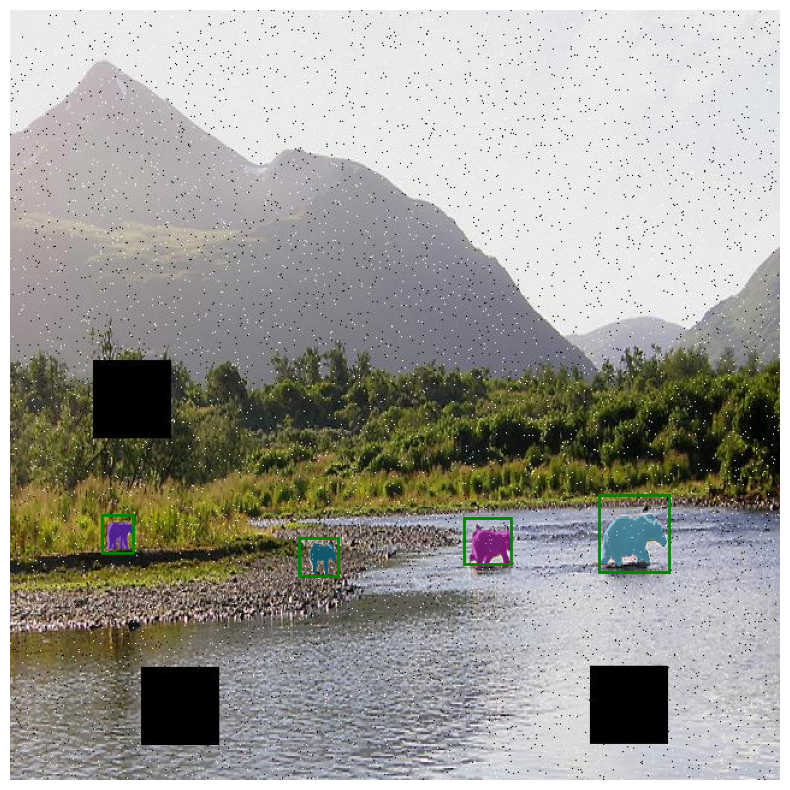

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [19]:
polygons= transform_mask_to_yolov8(masks.squeeze(1).cpu().numpy(), w, h, normalize=True)

In [20]:
len(polygons)

4

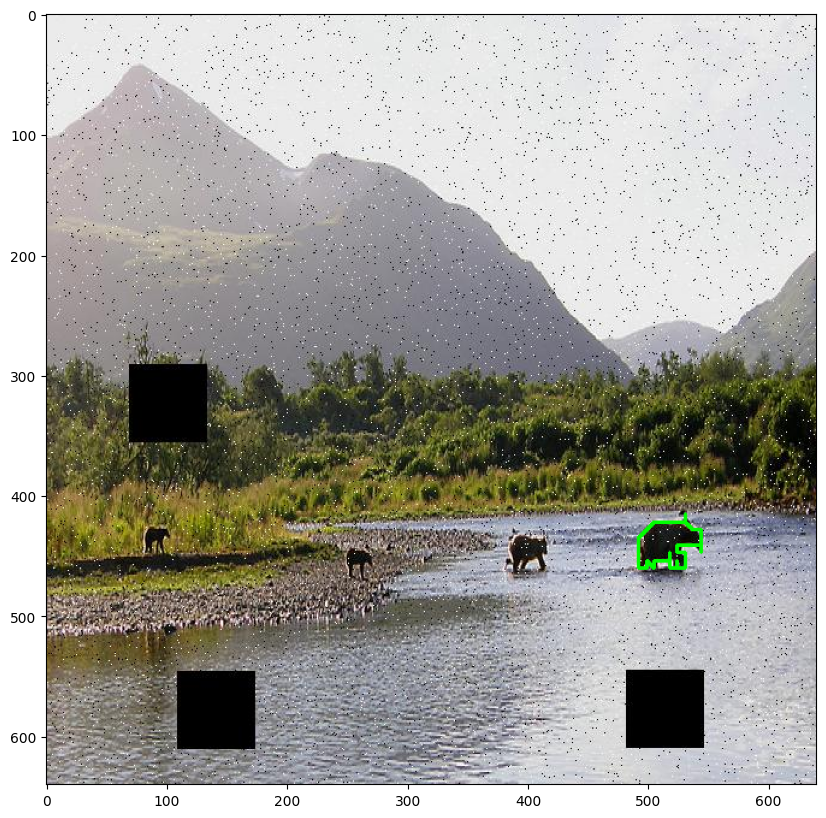

In [22]:
# draw polygon on one label only
img = image.copy()
line_thickness = 2
polygon = polygons[0].reshape(-1,2) #select first polygon
x1, y1 = polygon[0] 
to_scale= True
if to_scale:
    x1, y1 = int(w * x1), int(h * y1)   
for x2, y2 in polygon[0:]:
    if to_scale:
        x2, y2 = int(w * x2), int(h * y2)        
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=line_thickness)
    x1, y1 = x2, y2
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

## apply on all annotations

In [23]:
#take larger one. if multiple one
#polygon vs RLE (include hole inside object)

In [24]:
annots_tr_v2 = prediction(model=predictor, annotations=annots_tr)

100%|██████████| 1480/1480 [15:34<00:00,  1.58it/s]


In [25]:
annots_valid_v2 = prediction(model=predictor, annotations=annots_val)
annots_test_v2 = prediction(model=predictor, annotations=annots_test)

100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


In [26]:
for i, annot in annots_tr_v2.items():
    if len(annot['label']) != len(annot['bbxs']) or len(annot['bbxs']) != len(annot['polygons']):
        print(i)
        break

In [30]:
' '.join([str(x) for x in annots_tr_v2[0]['polygons'][0].reshape(-1).tolist()])

'0.6899999976158142 0.44999998807907104 0.6899999976158142 0.44999998807907104 0.6800000071525574 0.44999998807907104 0.6800000071525574 0.44999998807907104 0.6800000071525574 0.44999998807907104 0.6700000166893005 0.44999998807907104 0.6700000166893005 0.44999998807907104 0.6600000262260437 0.46000000834465027 0.6600000262260437 0.46000000834465027 0.6600000262260437 0.46000000834465027 0.6600000262260437 0.46000000834465027 0.6600000262260437 0.46000000834465027 0.6499999761581421 0.46000000834465027 0.6499999761581421 0.46000000834465027 0.6499999761581421 0.46000000834465027 0.6499999761581421 0.46000000834465027 0.6499999761581421 0.46000000834465027 0.6499999761581421 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6399999856948853 0.4699999988079071 0.6299999952316284 0.4699999988079071 0.6299999952316284 0.46999999880

In [31]:
def write_segmentation_labels(annotations, folder, split="train", new_folder="labels_seg"):
    if not os.path.exists(os.path.join(folder, split, new_folder)):
        os.makedirs(os.path.join(folder, split, new_folder))
    
    for cpt, annot in tqdm(annotations.items()):
        filename = os.path.splitext(annot['filename'])[0] + '.txt'
         
        
        file_path = os.path.join(folder, split, new_folder, filename)
        
        with open(file_path, 'w') as f:
            for label, ann in zip(annot['label'], annot['polygons']):
                ann_str = ' '.join([str(round(x, 2)) for x in ann.flatten().tolist()]).strip()
                temp = f'{label} {ann_str}\n'
                #print(temp)
                f.write(temp)
        #break
        
    print('save segmentations labels in: ', os.path.join(folder, split, new_folder))

In [138]:
write_segmentation_labels(annotations=annots_tr_v2, folder="datasets/bear_seg", split="train", new_folder="labels")

100%|██████████| 1480/1480 [00:04<00:00, 297.31it/s]

save segmentations labels in:  datasets/bear_seg/train/labels


In [140]:
write_segmentation_labels(annotations=annots_valid_v2, folder="datasets/bear_seg", split="valid", new_folder="labels")
write_segmentation_labels(annotations=annots_test_v2, folder="datasets/bear_seg", split="test", new_folder="labels")

100%|██████████| 92/92 [00:00<00:00, 976.62it/s]


save segmentations labels in:  datasets/bear_seg/valid/labels


100%|██████████| 94/94 [00:00<00:00, 954.47it/s]

save segmentations labels in:  datasets/bear_seg/test/labels


In [1]:
# we need to cp images now
!cp -r datasets/bear/train/images datasets/bear_seg/train
!cp -r datasets/bear/valid/images datasets/bear_seg/valid
!cp -r datasets/bear/test/images datasets/bear_seg/test